In [1]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r"D:\NUS_TERM2_CA2\Train"
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"


HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255)

datagen2 = ImageDataGenerator(
    rescale=1./255)


train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

validation_generator = datagen2.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


class_list = ["food", "landmark", "people"]



Found 2424 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


In [2]:
import numpy as np
import sklearn.metrics as metrics

seed = 29
np.random.seed(seed)

optmz = optimizers.Adam(lr=0.001)
# optmz = optimizers.RMSprop()

def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
  
    convLyr = Conv2D(numFilters,
                     kernel_size=kernelSz,
                     strides=strides,
                     padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4),
                     name=lyrName + '_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
        x = convLyr(x)
  
    return x


def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
  
    x = inputs
    for run in range(0, numBlocks):
        strides = 1
        blkStr = str(run + 1)
        
        if downsampleOnFirst and run == 0:
            strides = 2
            
        y = resLyr(inputs=x, numFilters=numFilters, strides=strides, lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y, numFilters=numFilters, activation=None, lyrName=names+'_Blk'+blkStr+'_Res2' if names else None) 
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x, numFilters=numFilters, kernelSz=1, 
                       strides=strides, activation=None, batchNorm=False, 
                       lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x = add([x, y], name=names+'_Blk'+blkStr+'_add' if names else None) 

        x = Activation('relu',  name=names+'_Blk'+blkStr+'_relu' if names else None)(x)   

    return x


def createResNetV1(inputShape=(32, 32, 3),
                   numClasses=3):
  
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(inputs=v,
                 numFilters=16,
                 numBlocks=3,
                 downsampleOnFirst=False,
                 names='Stg1')
#     v = Dropout(0.3)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg2')
#     v = Dropout(0.3)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=64,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg3')
#     v = Dropout(0.3)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=128,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg4')    
    v = Dropout(0.3)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=256,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg5')    
    v = Dropout(0.4)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=512,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg6')    
    v = Dropout(0.5)(v)
    
    
    v = AveragePooling2D(pool_size=8,
                         name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses,
                    activation='softmax',
                    kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])
  
    return model

model = createResNetV1(inputShape=(HEIGHT, WIDTH, 3))  # This is meant for training
modelGo = createResNetV1(inputShape=(HEIGHT, WIDTH, 3))  # This is used for final testing
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 300, 300, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 300, 300, 16) 64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 300, 300, 16) 0           Inpt_bn[0][0]                    
______________________________________________________________________________________________

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
import matplotlib.pyplot as plt
from PIL import Image

NUM_EPOCHS = 200
BATCH_SIZE = 64
num_train_images = 2424
num_test_images = 720

def lrSchedule(epoch):
    lr = 1e-2

    if epoch > 160:
        lr *= 0.5e-3

    elif epoch > 120:
        lr *= 1e-3

    elif epoch > 80:
        lr *= 1e-2

    elif epoch > 10:
        lr *= 1e-1

    print('Learning rate: ', lr)

    return lr


LRScheduler = LearningRateScheduler(lrSchedule)

modelname = 'createResNetV1'
filepath = modelname + '.hdf5'

checkpoint = ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=0,
                            save_best_only=True,
                            mode='max')
csv_logger = CSVLogger(modelname + '.csv')

callbacks_list = [checkpoint, csv_logger, LRScheduler]

# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
                    
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=NUM_EPOCHS,
                    workers=12, 
                    shuffle=True,
                    validation_steps=num_test_images // BATCH_SIZE,
                    steps_per_epoch=num_train_images // BATCH_SIZE, 
                    callbacks=callbacks_list)

Learning rate:  0.01
Epoch 1/200
37/37 [==============================] - 62s 2s/step - loss: 11.3835 - acc: 0.3581 - val_loss: 3637028.2727 - val_acc: 0.3068
Learning rate:  0.01
Epoch 2/200
37/37 [==============================] - 20s 547ms/step - loss: 6.3671 - acc: 0.3885 - val_loss: 54.4484 - val_acc: 0.2841
Learning rate:  0.01
Epoch 3/200
37/37 [==============================] - 21s 578ms/step - loss: 4.7861 - acc: 0.4459 - val_loss: 27.3308 - val_acc: 0.2727
Learning rate:  0.01
Epoch 4/200
37/37 [==============================] - 21s 564ms/step - loss: 3.7107 - acc: 0.5372 - val_loss: 4.7917 - val_acc: 0.3182
Learning rate:  0.01
Epoch 5/200
37/37 [==============================] - 22s 595ms/step - loss: 3.3237 - acc: 0.4865 - val_loss: 3.0682 - val_acc: 0.3068
Learning rate:  0.01
Epoch 6/200
37/37 [==============================] - 21s 571ms/step - loss: 2.8717 - acc: 0.4291 - val_loss: 2.6780 - val_acc: 0.4432
Learning rate:  0.01
Epoch 7/200
37/37 [========================

37/37 [==============================] - 9s 251ms/step - loss: 1.1403 - acc: 0.6486 - val_loss: 1.0606 - val_acc: 0.7273
Learning rate:  0.001
Epoch 54/200
37/37 [==============================] - 9s 252ms/step - loss: 1.2006 - acc: 0.6284 - val_loss: 1.1421 - val_acc: 0.5682
Learning rate:  0.001
Epoch 55/200
37/37 [==============================] - 9s 255ms/step - loss: 1.0869 - acc: 0.6655 - val_loss: 1.2044 - val_acc: 0.6705
Learning rate:  0.001
Epoch 56/200
37/37 [==============================] - 10s 262ms/step - loss: 1.1256 - acc: 0.6824 - val_loss: 1.0891 - val_acc: 0.6705
Learning rate:  0.001
Epoch 57/200
37/37 [==============================] - 9s 255ms/step - loss: 1.0914 - acc: 0.6284 - val_loss: 1.1842 - val_acc: 0.6932
Learning rate:  0.001
Epoch 58/200
37/37 [==============================] - 11s 292ms/step - loss: 1.1468 - acc: 0.6385 - val_loss: 1.0950 - val_acc: 0.6705
Learning rate:  0.001
Epoch 59/200
37/37 [==============================] - 10s 259ms/step - loss

37/37 [==============================] - 9s 255ms/step - loss: 0.8883 - acc: 0.7027 - val_loss: 0.8678 - val_acc: 0.7273
Learning rate:  0.0001
Epoch 106/200
37/37 [==============================] - 9s 254ms/step - loss: 0.9133 - acc: 0.6926 - val_loss: 0.8425 - val_acc: 0.6932
Learning rate:  0.0001
Epoch 107/200
37/37 [==============================] - 11s 284ms/step - loss: 0.8859 - acc: 0.7230 - val_loss: 0.8664 - val_acc: 0.6932
Learning rate:  0.0001
Epoch 108/200
37/37 [==============================] - 9s 255ms/step - loss: 0.8714 - acc: 0.7297 - val_loss: 0.8725 - val_acc: 0.6818
Learning rate:  0.0001
Epoch 109/200
37/37 [==============================] - 9s 254ms/step - loss: 0.9570 - acc: 0.6791 - val_loss: 0.8578 - val_acc: 0.6705
Learning rate:  0.0001
Epoch 110/200
37/37 [==============================] - 9s 254ms/step - loss: 0.9266 - acc: 0.7162 - val_loss: 0.8794 - val_acc: 0.7614
Learning rate:  0.0001
Epoch 111/200
37/37 [==============================] - 9s 250ms/s

37/37 [==============================] - 10s 262ms/step - loss: 0.7699 - acc: 0.7838 - val_loss: 0.7877 - val_acc: 0.7273
Learning rate:  1e-05
Epoch 158/200
37/37 [==============================] - 10s 262ms/step - loss: 0.7767 - acc: 0.7973 - val_loss: 0.7876 - val_acc: 0.7273
Learning rate:  1e-05
Epoch 159/200
37/37 [==============================] - 10s 266ms/step - loss: 0.8226 - acc: 0.7601 - val_loss: 0.7991 - val_acc: 0.7273
Learning rate:  1e-05
Epoch 160/200
37/37 [==============================] - 10s 263ms/step - loss: 0.8306 - acc: 0.7365 - val_loss: 0.7950 - val_acc: 0.7273
Learning rate:  1e-05
Epoch 161/200
37/37 [==============================] - 10s 262ms/step - loss: 0.7892 - acc: 0.7770 - val_loss: 0.7923 - val_acc: 0.7273
Learning rate:  5e-06
Epoch 162/200
37/37 [==============================] - 10s 264ms/step - loss: 0.8713 - acc: 0.7331 - val_loss: 0.7869 - val_acc: 0.7159
Learning rate:  5e-06
Epoch 163/200
37/37 [==============================] - 10s 257ms/s

In [4]:
history_dict = history.history
history_dict.keys()

#

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

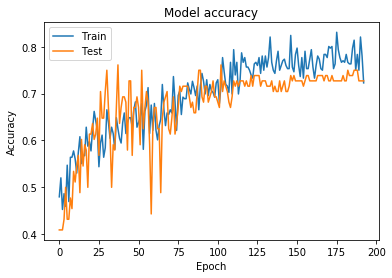

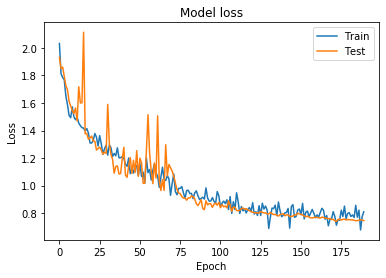

In [5]:
import matplotlib.pyplot as plt
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
plt.plot(history.history['acc'][7:])
plt.plot(history.history['val_acc'][7:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = class_list #= ["food", "landmark", "people"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

90/90 [==============================] - 49s 548ms/step
Confusion Matrix
[[105 112  76]
 [ 88  77  53]
 [ 83  70  56]]
Classification Report
              precision    recall  f1-score   support

        food       0.38      0.36      0.37       293
    landmark       0.30      0.35      0.32       218
      people       0.30      0.27      0.28       209

    accuracy                           0.33       720
   macro avg       0.33      0.33      0.33       720
weighted avg       0.33      0.33      0.33       720



In [7]:
score = model.evaluate_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
print(model.metrics_names)
print(score)

90/90 [==============================] - 12s 135ms/step - loss: 0.6806 - acc: 0.8153
['loss', 'acc']
[0.6806399908330706, 0.81527776]


In [ ]:
#Save & Load Model

In [8]:
model_json = model.to_json()
with open("ca2_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights('ca2_model.h5')
print("Saved model to disk")

Saved model to disk


In [9]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('ca2_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ca2_model.h5")
print("Loaded model from disk")

W0924 21:04:44.032352  1780 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 21:04:44.033380  1780 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 21:04:44.034315  1780 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.ini

Loaded model from disk


In [10]:
loaded_model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
score = loaded_model.evaluate_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
print(loaded_model.metrics_names)
print(score)

90/90 [==============================] - 12s 130ms/step - loss: 0.6806 - acc: 0.8153
['loss', 'acc']
[0.6806399908330706, 0.81527776]
